# Apprentissage de paramètres par maximum de vraisemblance
L'objectif est d'apprendre grâce à l'estimateur de maximum de vraisemblance les paramètres de lois normales à partir d'un ensemble de données. Ces lois normales seront ensuite exploitées pour faire de la classification

Ici, notre base de données d'apprentissage est la base USPS. Celle-ci contient les images réelles de chiffres provenant de codes postaux écrits manuellement et scannés par le service des postes américain. Ces données scannées ont été normalisées de manière à ce qu'elles soient toutes des images de 16x16 pixels en teintes de gris, cf. Le Cun et al., 1990:

Y. LeCun, O. Matan, B. Boser, J. S. Denker, et al. (1990) *Handwritten zip code recognition with multilayer networks*. In ICPR, volume II, pages 35–40.

Voici quelques exemples d'images de cette base : 
np.array(
<img src="usps.png" title="Quelques exemples">


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

## Chargement des données et premières visualisations

Nous utiliserons la librairie pickle qui permet de sérialiser les objets en python (ie, les sauver et les charger très facilement).
Une fois les données chargées, nous allons étudier très rapidement la distribution des classes, visualiser une imagette de chiffre et comprendre l'encodage de ces chiffres.

(array([488., 412., 311., 260., 306., 244., 261., 282., 224., 281.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

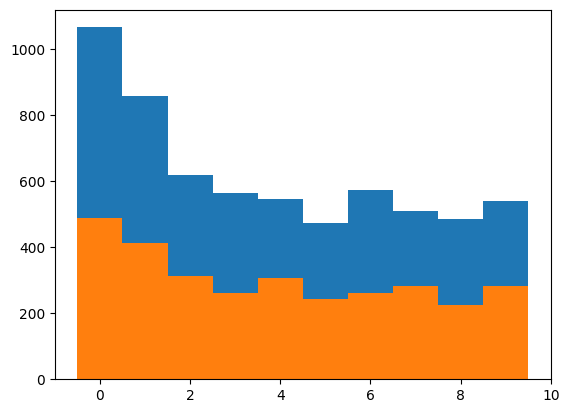

In [2]:
# Chargement des données
data = pkl.load(open("usps.pkl",'rb')) 
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
X_train = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
X_test = np.array(data["X_test"],dtype=float)
Y_train = data["Y_train"]
Y_test = data["Y_test"]

# visualisation de la distribution des étiquettes (dans les 10 classes de chiffres)
plt.figure()
plt.hist(Y_train, np.linspace(-0.5,9.5,11))
plt.hist(Y_test, np.linspace(-0.5,9.5,11))
#plt.savefig("distr_classes.png")

(6229, 256)
(3069, 256) (6229,) (3069,)


Text(0.5, 1.0, 'Image de : 6')

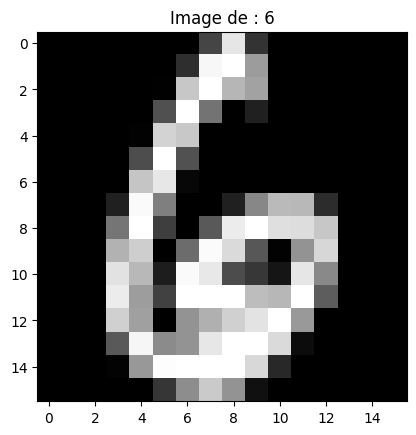

In [3]:
# prise en main des matrices X, Y
print(X_train.shape)
# 6229 images composées de 256 pixels (image = 16x16)
print(X_test.shape,Y_train.shape, Y_test.shape)

# Affichage de l'image 18 de la base de données et récupération de l'étiquette associée:
# (1) remise en forme de la ligne de 256 pixels en 16x16
# (2) affichage avec imshow (en niveaux de gris)
# (3) récupération de l'étiquette dans Y_train

plt.figure()
plt.imshow(X_train[18].reshape(16,16),cmap="gray")
plt.title("Image de : {}".format(Y_train[18]))

In [4]:
# analyse des valeurs min et max, recherche du nombre de niveaux de gris dans les images:
print(X_train.min(),X_train.max() )
print("niveaux de gris : ", len(np.unique(X_train))) 


0.0 2.0
niveaux de gris :  2001


# A. Apprentissage et évaluation d'un modèle gaussien naïf

## A1- Maximum de vraisemblance 

Nous allons étudier la distribution de probabilité des teintes de gris des images (en fait, nous allons étudier sa fonction de densité car on travaille sur des variables aléatoires continues) . Nous allons faire l'hypothèse (certes un peu forte mais tellement pratique) que, dans chaque classe, les teintes des pixels sont mutuellement indépendantes. 

Autrement dit, si $X_i, i\in \{0,...,255\}$ représente la variable aléatoire "intensité de gris du ième pixel", alors $p(X_0,…,X_{255})$ représente la fonction de densité des teintes de gris des images de la classe et: 

$$p(X_0,,…,X_{255})=\prod_{i=0}^{255} p(X_i)$$

Ainsi, en choisissant au hasard une image dans l'ensemble de toutes les images possibles de la classe, si celle-ci correspond au tableau `np.array([x_0,...,x_255])`, où les $x_i$ sont des nombres réels compris entre 0 et 2, alors la valeur de la fonction de densité de l'image est égale à $p(x_0,...,x_{255}) = \prod^{255}_{i=0}p(x_i)$. 

Nous allons de plus supposer que chaque $X_i$ suit une distribution normale de paramètres $(μ_i,σ^2_i)$. Autrement dit, $$\forall i\in\{0,...,255\}, X_i \sim {\cal N}(μ_i,σ^2_i)$$ 

Par maximum de vraisemblance, estimez, pour une classe donnée, l'ensemble des paramètres $(μ_0,…,μ_{255})$ et $(σ^2_0,…,σ^2_{255})$ pour chaque classe (chiffre de 0 à 9). Pour cela, écrivez une fonction `learnML_parameters : float np.array x float np.array -> float np.array x float np.array` qui, étant donné le tableau d'images , renvoie un couple de tableaux, le premier élément du couple correspondant à l'ensemble des $μ_i$ et le 2ème à l'ensemble des $σ^2_i$. C'est-à-dire que `learnML_parameters` renverra deux matrices:
$$ mu \in \mathbb R^{10 \times 256}, sig \in \mathbb R^{10 \times 256}$$

* mu contient les moyennes des 256 pixels pour les 10 classes
* std contient les écarts-types des 256 pixels pour les 10 classes



In [5]:
def learnML_parameters(X,Y):
    # votre code
    mu=np.zeros((10,256))
    sig=np.zeros((10,256))
    for i in range(10):
            mu[i]=X[Y==i].mean(axis=0)
            sig[i]=X[Y==i].std(axis=0)            
    return mu,sig

In [6]:
mu,sig = learnML_parameters ( X_train, Y_train )
print(mu.shape, sig.shape) # doit donner (10, 256) (10, 256)

(10, 256) (10, 256)


Check: pour la classe 0, les paramètres doivent être les suivants
```
mu[0]=
[1.53774208e-03 4.46785940e-03 1.71216078e-02 6.31194048e-02
 1.84061642e-01 4.71391665e-01 8.97640989e-01 1.15019928e+00
 ...
 1.42675380e+00 1.03130694e+00 5.32240296e-01 1.74166387e-01
 3.57644515e-02 5.52804884e-03 4.36592998e-04 0.00000000e+00]
sig[0]=
[5.01596286e-02 7.93695089e-02 1.46489017e-01 2.65522337e-01
 4.42306204e-01 6.35148001e-01 7.40462105e-01 7.48387032e-01
 ...
 6.62741331e-01 6.75677391e-01 5.86224763e-01 3.56460503e-01
 1.71512333e-01 5.67475697e-02 1.20193571e-02 0.00000000e+00]
```

In [7]:
print(mu[0], sig[0])

[1.53774208e-03 4.46785940e-03 1.71216078e-02 6.31194048e-02
 1.84061642e-01 4.71391665e-01 8.97640989e-01 1.15019928e+00
 1.02070900e+00 6.16785408e-01 2.50766353e-01 8.09903122e-02
 1.49310824e-02 3.87033274e-03 1.70898437e-04 0.00000000e+00
 2.35601434e-03 7.93762565e-03 5.18573940e-02 2.00940178e-01
 5.59411980e-01 1.10202446e+00 1.53532559e+00 1.66378367e+00
 1.60174400e+00 1.37845195e+00 9.19353768e-01 4.15479248e-01
 1.22346858e-01 3.01527050e-02 4.24372534e-03 5.63428995e-06
 5.88210737e-03 3.00679919e-02 1.45009354e-01 4.68428296e-01
 9.87103163e-01 1.46020945e+00 1.63103905e+00 1.59445846e+00
 1.52785712e+00 1.52155705e+00 1.36630499e+00 9.33882722e-01
 4.29464169e-01 1.16865928e-01 2.02650169e-02 1.02089895e-03
 7.91202062e-03 6.88018163e-02 3.30783411e-01 8.24194929e-01
 1.31254975e+00 1.54256605e+00 1.44943446e+00 1.21191395e+00
 1.09220056e+00 1.22655949e+00 1.39070742e+00 1.27821441e+00
 8.46682745e-01 3.48925595e-01 8.07226924e-02 4.64439750e-03
 1.59532081e-02 1.766754

## A2- Log-vraisemblance d'une image pour une classe

Fonction `log_likelihood : float np.array x float np.array x float np.array -> float` qui, étant donné une image (donc un tableau de 256 nombres réels) et un couple de paramètres `( array ( [μ0,…,μ255] ), array ( [σ20,…,σ255] ) )`, renvoie la log-vraisemblance qu'aurait l'image selon cet ensemble de $μ_i$ et $σ_i$ (correspondant à une classe de chiffre). En mettant $-\frac{1}{2}$ en facteur : 

$$\log(p(x_0,\cdots,x_{255})=\sum_{i=0}^{255} \log p(x_i)=-\frac{1}{2}\sum_{i=0}^{255} \left[ \log(2\pi \sigma^2_i) + \frac{(x_i-\mu_i)^2}{\sigma_i^2} \right]$$


**Attention**: dans la matrice `sig` calculée précédement, pour certains pixels de certaines classes, la valeur de $σ^2$ est égale à $0$ (toutes les images de la base d'apprentissage avaient exactement la même valeur sur ce pixel). 
* cette valeur pose problème dans le calcul précédent (division par 0)
* Différente manière de traiter ce problème:
 * faible valeur par défaut de $\sigma$ reflétant une variance très faible mais évitant la division par 0 (usage de  `np.maximum`par exemple)
 * vraisemblance de 1 pour le ou les pixels impactés

In [8]:
# on utilisera dans le suite le paramètre defeps: 
#    positif, il donne la valeur minimale d'écart type
#    = -1, il faut prendre une vraisemblance de 1 pour les pixels concernés
def log_likelihood(img, mu, sig, defsig = 1e-5):
    if defsig == -1:
         img=img[sig>0]
         mu=mu[sig>0]
         sig=sig[sig>0]
         return -0.5*np.sum(np.log(2*np.pi*sig**2)+((img-mu)**2)/sig**2)
    else:
        sigma=np.maximum(sig,defsig) 
        return -0.5*np.sum(np.log(2*np.pi*sigma**2)+((img-mu)**2)/sigma**2)
    

In [9]:
print(log_likelihood(X_train[0], mu[0], sig[0],-1)) 
# vraisemblance de l'image 0 selon les paramètres de la classe 0

print([log_likelihood(X_train[0], mu[i], sig[i],-1) for i in range(10)]) 
# vraisemblance de l'image 0 pour toutes les classes

-111.88760421521837
[-111.88760421521837, -1716629080.9897287, -364.8317101985202, -487.01085544875843, -544.9100255404517, -387.75946984198, -59747.83956373113, -581523.2639945432, -303.76250341168577, -13497.825910916887]


Check : le code ci-dessus avec une valeur par défaut de $1e-5$ pour les sigmas nuls doit donner:
```
-90.69963035168726
```
puis pour toutes les classes:
```
[-90.69963035168726, -231211311074.5327, -364.8317101985202, -487.01085544875843, -513.128064745155, -387.75946984198, -59610.117733618186, -75567222244.77489, -271.980542616389, -857252055.4774221]
```

Avec une vraisemblance de 1 pour les pixels problématiques:
```
[-111.88760421521835, -1716629080.989729, -364.83171019852006, -487.01085544875855, -544.9100255404516, -387.7594698419803, -59747.8395637312, -581523.2639945432, -303.762503411686, -13497.825910916881]
```

## A3- Classification d'une image
Fonction `classify_image : float np.array x float np.array x float np.array -> int` qui, étant donnée une image et l'ensemble de paramètres déterminés dans les questions précédentes, renvoie la classe la plus probable de l'image, c'est-à-dire celle dont la log-vraisemblance est la plus grande.

In [10]:
def classify_image(img, mu, sig, defsig=1e-5):
    res=[log_likelihood(img, mu[i], sig[i],defsig) for i in range(10)]
    return np.argmax(res)

In [11]:
# check
classify_image(X_train[0], mu, sig, -1)
# l'image 0 est de la classe 0

0

## A4- Classification de toutes les images
Fonction `classify_all_images : float np.array x float np.array x float np.array -> float np.array` qui, étant donné un tableau $X$ des images ($N \times 256$) et l'ensemble de paramètres déterminés dans les questions précédentes, renvoie un tableau $\hat Y$ qui donne la prédiction de classe pour toutes les images

In [12]:
def classify_all_images(X, mu, sig, defsig=1e-5):
    return [classify_image(X[i],mu,sig,defsig) for i in range(len(X))]


In [13]:
# check
Y_train_hat = classify_all_images(X_train, mu, sig, -1)

print(Y_train_hat) # doit rendre: [0 9 7 ... 6 3 2]

[0, 9, 7, 8, 2, 5, 2, 0, 9, 0, 8, 3, 0, 6, 6, 5, 2, 1, 6, 4, 0, 6, 5, 9, 8, 4, 0, 7, 6, 5, 4, 4, 2, 7, 6, 6, 6, 2, 1, 1, 8, 1, 1, 8, 0, 3, 1, 1, 8, 0, 7, 2, 5, 0, 2, 9, 9, 2, 0, 8, 6, 0, 6, 9, 8, 7, 9, 1, 3, 5, 1, 0, 0, 6, 6, 2, 1, 3, 8, 0, 0, 5, 8, 6, 2, 1, 0, 1, 0, 8, 3, 4, 0, 9, 1, 5, 0, 0, 0, 2, 6, 8, 1, 9, 8, 3, 0, 9, 2, 2, 0, 0, 1, 5, 2, 0, 0, 1, 8, 0, 9, 3, 9, 1, 1, 8, 5, 0, 0, 9, 0, 1, 2, 1, 8, 1, 9, 1, 0, 3, 6, 6, 8, 5, 9, 0, 8, 2, 3, 2, 0, 1, 7, 9, 0, 2, 0, 3, 8, 0, 7, 8, 0, 8, 8, 1, 8, 2, 8, 5, 9, 2, 7, 0, 8, 0, 2, 6, 6, 0, 6, 0, 8, 2, 9, 9, 9, 3, 1, 0, 5, 1, 9, 2, 4, 0, 2, 1, 0, 3, 9, 1, 7, 9, 8, 9, 0, 7, 1, 9, 1, 0, 4, 9, 6, 1, 2, 1, 0, 9, 1, 5, 0, 3, 1, 9, 2, 0, 8, 9, 6, 7, 8, 0, 0, 9, 1, 9, 9, 3, 9, 7, 8, 4, 1, 9, 4, 7, 9, 6, 7, 9, 3, 3, 1, 3, 2, 8, 2, 2, 4, 8, 3, 6, 9, 6, 9, 1, 5, 4, 2, 4, 8, 0, 4, 0, 1, 1, 6, 2, 4, 0, 7, 9, 5, 5, 3, 7, 6, 2, 8, 8, 1, 0, 6, 4, 3, 6, 0, 2, 0, 8, 0, 5, 0, 0, 1, 6, 8, 8, 2, 6, 0, 6, 6, 1, 8, 9, 8, 8, 0, 4, 3, 1, 9, 2, 2, 7, 0, 8, 0, 2, 2, 

## A5-Matrice de confusion et affichage du résultat des classifications

La matrice de confusion est de la forme $C \times C$ où $C$ est le nombre de classe. Les lignes sont les vraies classes, les colonnes sont les classes prédites. Chaque case (i,j) contient le nombre d'images correspondant à la vraie classe i et à la prédiction j.
Si le classifieur est performant, on doit observer des pics sur la diagonale. 

La fonction `matrice_confusion(Y, Y_hat)` prend en argument un vecteur d'étiquettes réelles et un vecteur de même taille d'étiquettes prédites et retourne la matrice de confusion.

In [14]:
def matrice_confusion(Y, Y_hat):
    m = np.zeros((10,10))
    for y,y_hat in zip(Y,Y_hat):
        m[y][y_hat]+=1
    return m

Taux de bonne classification: 0.8099213356879114


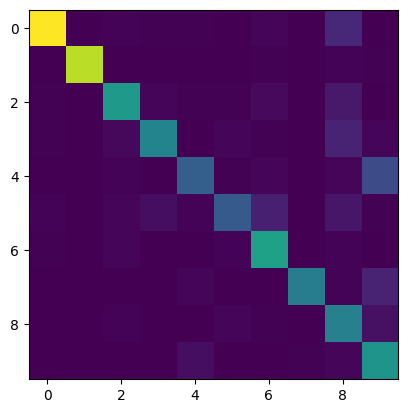

In [15]:
# affichage de la matrice de confusion
m = matrice_confusion(Y_train, Y_train_hat)

print("Taux de bonne classification: {}".format(np.where(Y_train == Y_train_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m)

## A6- Ensemble d'apprentissage, ensemble de test

Dans la procédure que nous avons suivie jusqu'ici,les mêmes données servent à apprendre les paramètres et à évaluer le modèle. Afin de réduire ce biais, nous allons maintenant évaluer les performances sur les données de test.

Taux de bonne classification: 0.7934180514825676
3069


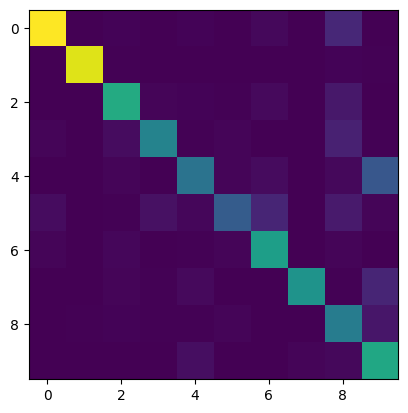

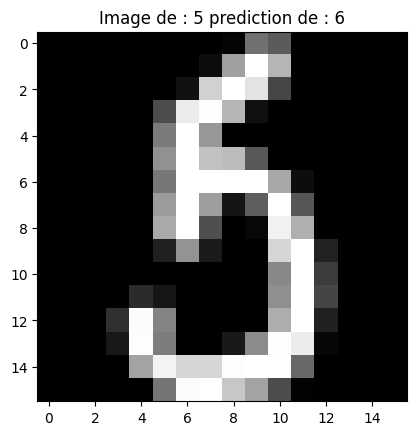

In [16]:
# votre code
mu_train,sig_train = learnML_parameters ( X_train, Y_train )

Y_test_hat = classify_all_images(X_test, mu_train, sig_train, -1)
m2 = matrice_confusion(Y_test, Y_test_hat)

print("Taux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m2)
print(len(Y_test_hat))

for i in range(len (Y_test_hat)):
    if Y_test_hat[i] != Y_test[i]:
        plt.figure()
        plt.imshow(X_test[i].reshape(16,16),cmap="gray")
        plt.title("Image de : {}".format(Y_test[i])+" prediction de : {}".format(Y_test_hat[i]))
        break

# Autres modélisations possibles pour les images

## B. Modélisation par une loi de Bernoulli

Soit les indices $i$ donnant les images et les indices $j$ référant aux pixels dans l'image, nous cherchons à déterminer la probabilité d'illumination d'un pixel $j$ pour une collection d'image (d'une seule classe, par exemple les $0$).

Collection de $0$:
$$ X = \{\mathbf{x_i}\}_{i = 1,\ldots, N}, \qquad \mathbf{x_i} \in \{0,1\}^{256}$$

Modélisation de la variable de Bernoulli $X_j$, valeur du pixel $j$ en écriture factorisée:
$$ p(X_j = x_{ij}) = p_j^{x_{ij}} (1-p_j)^{(1-x_{ij})} = \left\{
\begin{array}{ccc}
p_j & \mbox{ si } x_{ij} = 1 \\
1-p_j & \mbox{ si } x_{ij} = 0 \\
\end{array}
\right.$$

Expression de la vraisemblance

Maximisation de la vraisemblance $\Rightarrow$ $\nabla_{\theta} \mathcal L(X, \theta) = 0$:

$$p_j^\star = \frac{\sum_i x_{ij}}{N} $$

Intuitif: nombre de $1$ pour le pixel $j$ divisé par le nombre d'image = pourcentage d'illumination du pixel $j$

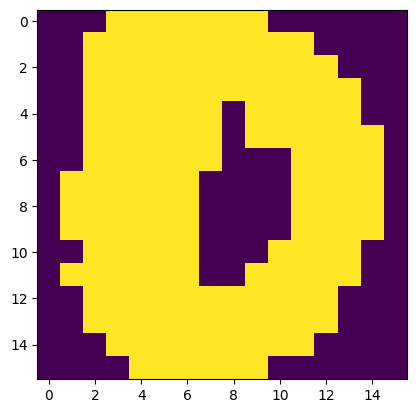

In [17]:
# binarisation des images pour coller avec l'hypothèse de Bernoulli:

Xb_train = np.where(X_train>0, 1, 0)
Xb_test  = np.where(X_test>0, 1, 0)

# affichage d'une image binaire:
plt.figure()
plt.imshow(Xb_train[0].reshape(16,16))

### B-1: Ecrire la fonction d'apprentissage des paramètres qui retourne la matrice theta suivante:

$$ \theta^\star = 
 \left[
 \begin{array}{ccc}
     [p_0^\star, \ldots, p_{255}^\star] & \mbox{Paramètres optimaux de la classe 0 au sens du max de vraisembalnce} \\
     [p_0^\star, \ldots, p_{255}^\star] & \mbox{Paramètres optimaux de la classe 1 au sens du max de vraisembalnce} \\
\vdots & \\
     [p_0^\star, \ldots, p_{255}^\star] & \mbox{Paramètres optimaux de la classe 9 au sens du max de vraisembalnce} \\
\end{array}
 \right]
 $$
 
 Il faut ensuite calculer les :
 $$ \log p (\mathbf{x_i} | \theta^{(c)}) = \sum_j \log p(X_j = x_{ij})  = \sum_j {x_{ij}} \log p_j + {(1-x_{ij})}\log(1-p_j)$$
 
 Faire passer les $N$ images dans les $C$ modèles donne un tableau de la forme :
 $$ \log p (X | \theta) =  \left[
 \begin{array}{cccc}
 \log p (\mathbf{x_0} | \theta^{(0)}) &  \log p (\mathbf{x_0} | \theta^{(1)}) & \ldots &  \log p (\mathbf{x_0} | \theta^{(9)}) \\
 & \vdots & \\
 \log p (\mathbf{x_N} | \theta^{(0)}) &  \log p (\mathbf{x_N} | \theta^{(1)}) & \ldots &  \log p (\mathbf{x_N} | \theta^{(9)}) \\
  \end{array}
 \right]
 $$
 
 Chaque ligne donne pour une image sa probabilité d'appartenance à chaque classe $c$.
 Un argmax par ligne donne une estimation de la classe.

In [18]:
def learnBernoulli ( X,Y ):
    teta = np.zeros((10,256))
    for c in  range(10):
        teta[c]=np.sum(X[Y==c],axis=0)/np.sum(Y==c)
    return teta

In [19]:
theta = learnBernoulli ( Xb_train,Y_train )
print(theta.shape)
print(theta)

(10, 256)
[[0.00093897 0.00657277 0.03192488 ... 0.02347418 0.00375587 0.        ]
 [0.         0.         0.         ... 0.00233372 0.         0.        ]
 [0.01941748 0.05987055 0.13430421 ... 0.27993528 0.20711974 0.11326861]
 ...
 [0.06666667 0.16078431 0.2745098  ... 0.         0.         0.        ]
 [0.01033058 0.05371901 0.1322314  ... 0.01446281 0.00206612 0.        ]
 [0.0037037  0.0037037  0.01111111 ... 0.00555556 0.00185185 0.        ]]


Check du résultat précédent:
```
(10, 256)
[[0.00093897 0.00657277 0.03192488 ... 0.02347418 0.00375587 0.        ]
 [0.         0.         0.         ... 0.00233372 0.         0.        ]
 [0.01941748 0.05987055 0.13430421 ... 0.27993528 0.20711974 0.11326861]
 ...
 [0.06666667 0.16078431 0.2745098  ... 0.         0.         0.        ]
 [0.01033058 0.05371901 0.1322314  ... 0.01446281 0.00206612 0.        ]
 [0.0037037  0.0037037  0.01111111 ... 0.00555556 0.00185185 0.        ]]
```

### B-2: Ecrire ensuite une fonction de calcul de la vraisemblance d'une image par rapport à ces paramètres

**Attention** $log(0)$ n'est pas défini et $log(1-x)$ avec $x=1$ non plus ! 
La solution à ce problème est assez simple, il suffit de seuiller les probabilités d'illumination entre $\epsilon $ et $1-\epsilon$.

In [20]:
def logpobsBernoulli(X, theta, defeps=1e-4):
    return [[sum(X[j]*np.log(np.maximum(theta[i][j],defeps))+(1-X[j])*np.log(np.maximum(1-theta[i][j],defeps)) for j in range(256))] for i in range(10)]


In [21]:
logpobsBernoulli(Xb_train[0], theta)

[[-84.9249739733205],
 [-742.6530662882307],
 [-171.38766957119802],
 [-175.31753619348316],
 [-216.95685847734887],
 [-161.36508121487208],
 [-208.21403429058336],
 [-360.1675461824077],
 [-172.16255291975315],
 [-287.87495768034563]]

### B-3: Evaluer ensuite vos performances avec les mêmes méthodes que précédemment

Taux de bonne classification: 0.8533724340175953


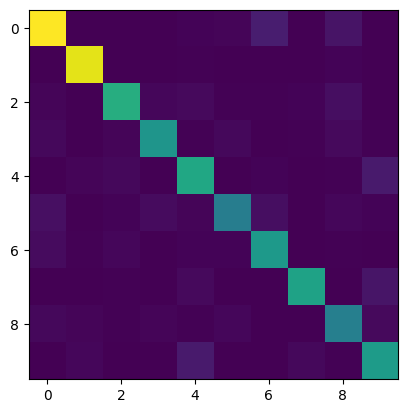

In [22]:
Y_test_hat = [np.argmax(logpobsBernoulli(Xb_test[i], theta)) for i in range (len(Xb_test))]
m = matrice_confusion(Y_test, Y_test_hat)

print("Taux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m)

# C. Modélisation des profils de chiffre

Il est possible de jouer avec les profils des images: chaque image peut etre séparée en 16 lignes et pour chaque ligne, nous modélisons l'apparition du premier pixel allumé avec une loi géométrique. Ci-dessous la fonction de transformation de la base d'image et son application.

In [23]:
# modelisation geometrique
def transfoProfil(X):
    x2 = []
    for x in X:
        ind = np.where(np.hstack((x.reshape(16, 16), np.ones((16,1))))>0.3)
        x2.append( [ind[1][np.where(ind[0] == i)][0] for i in range(16)])
    return np.array(x2)

Xg_train = transfoProfil(Xb_train)
Xg_test  = transfoProfil(Xb_test)

In [24]:
print(Xg_train[0]) # [3 2 2 2 2 2 2 1 1 1 2 1 2 2 3 4]
# une image est maintenant représentée par 16 entiers

[3 2 2 2 2 2 2 1 1 1 2 1 2 2 3 4]


### C-123:  Fonctions d'apprentissage des paramètres et de calcul de la vraisemblance avec cette modélisation

[-146.66741126 -147.35610561 -144.93998957 -146.61696551 -146.9447365
 -146.27862569 -147.22734391 -145.51314966 -146.65188873 -147.1445449 ]
Taux de bonne classification: 0.020202020202020204


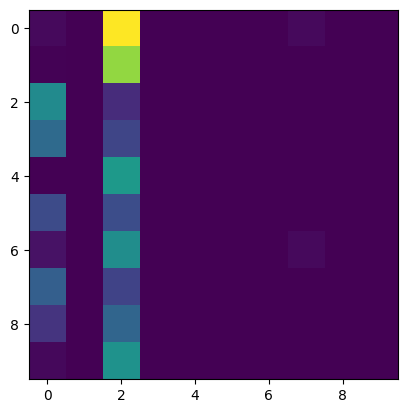

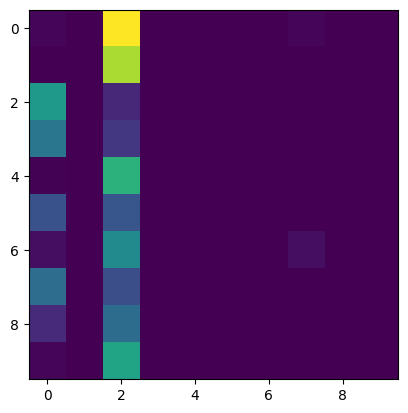

In [25]:
def learnGeom(X, Y):
    theta = np.zeros((10, 16))
    for i in range(10):
        X_class = X[Y == i]
        for j in range(16):
            ratio_zero= np.mean(X_class[:, j] == 0)
            if  ratio_zero == 1:
                theta[i,j] = 0
            else:
                theta[i,j] = 1 / (1 - ratio_zero)
    return theta
    
def logpobsGeom(X, theta):
    log_probs = np.zeros(10)
    for i in range(10):
        log_probs[i] = np.sum(np.log(np.maximum(1 - theta[i, :],1e-4)) + np.log(np.maximum(theta[i, :],1e-4)) * X[:16])

    return log_probs

theta = learnGeom(Xg_train, Y_train)

print(logpobsGeom(Xg_test[1], theta))

Y_train_hat = [np.argmax(logpobsGeom(Xg_train[i], theta)) for i in range (len(Xg_train))]
Y_test_hat  = [np.argmax(logpobsGeom(Xg_test[i], theta)) for i in range (len(Xg_test))]

ma = matrice_confusion(Y_train, Y_train_hat)
mt = matrice_confusion(Y_test, Y_test_hat)

print("Taux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))

plt.figure()
plt.imshow(ma)
plt.figure()
plt.imshow(mt)

# Avec un score de 0.02 le modèle est sans doute mal implémenté

# D. Fusion de modèle

Fusion des sorties des modèles précédents pour améliorer la performance globale en test

* En faisant voter les classifieurs
* En pondérant ces votes par leurs performances en apprentissage
* En fusionnant les vraisemblances

In [27]:
### On recupere les performances en apprentissage

def getPourcentage(Y_pred,Y_reel):
    nombres_identiques = 0
    for i in range(len(Y_pred)):
        if Y_pred[i] == Y_reel.tolist()[i]:
            nombres_identiques += 1
    pourcentage = (nombres_identiques / len(Y_pred))
    return pourcentage

mu,sig = learnML_parameters ( X_train, Y_train )
ml_train=[[log_likelihood(X_train[j], mu[i], sig[i],-1) for i in range(10)] for j in range(len(X_train))]
Y_ml_train_pred=[np.argmax(t) for t in ml_train]
ml_perf=getPourcentage(Y_ml_train_pred,Y_train)
print("Performance en apprentissage: {}".format(ml_perf))

theta = learnBernoulli ( Xb_train,Y_train )
bern_train = [(logpobsBernoulli(Xb_train[i], theta)) for i in range (len(Xb_train))]
bern_train=[np.squeeze(arr).tolist() for arr in bern_train]
Y_bern_train_pred=[np.argmax(t) for t in bern_train]
bern_perf=getPourcentage(Y_bern_train_pred,Y_train)
print("Performance en apprentissage: {}".format(bern_perf))

theta2 = learnGeom(Xg_train, Y_train)
geom_train  = [(logpobsGeom(Xg_train[i], theta2)) for i in range (len(Xg_train))]
geom_train= [arr.tolist() for arr in geom_train]
Y_geom_train_pred=[np.argmax(t) for t in geom_train]
geom_perf=getPourcentage(Y_geom_train_pred,Y_train)
print("Performance en apprentissage: {}".format(geom_perf))


Performance en apprentissage: 0.8099213356879114
Performance en apprentissage: 0.8609728688393
Performance en apprentissage: 0.02472306951356558


In [28]:
### Calcul des vraissamblances et des prédictions de chaque modèle


mu,sig = learnML_parameters ( X_train, Y_train )
ml_test=[[log_likelihood(X_test[j], mu[i], sig[i],-1) for i in range(10)] for j in range(len(X_test))]
Y_ml_test_pred=[np.argmax(t) for t in ml_test]
print(Y_ml_test_pred)

theta = learnBernoulli ( Xb_train,Y_train )
bern_test = [(logpobsBernoulli(Xb_test[i], theta)) for i in range (len(Xb_test))]
bern_test=[np.squeeze(arr).tolist() for arr in bern_test]
Y_bern_test_pred=[np.argmax(t) for t in bern_test]
print(Y_bern_test_pred)

theta2 = learnGeom(Xg_train, Y_train)
geom_test  = [(logpobsGeom(Xg_test[i], theta2)) for i in range (len(Xg_test))]
geom_test= [arr.tolist() for arr in geom_test]
Y_geom_test_pred=[np.argmax(t) for t in geom_test]
print(Y_geom_test_pred)


[2, 0, 0, 2, 7, 6, 0, 6, 1, 9, 6, 9, 6, 8, 5, 0, 0, 9, 7, 8, 0, 8, 0, 0, 9, 8, 2, 8, 9, 0, 7, 6, 8, 6, 0, 9, 5, 6, 9, 3, 7, 2, 5, 0, 8, 9, 2, 1, 0, 6, 9, 1, 0, 0, 5, 7, 9, 7, 4, 9, 7, 2, 6, 8, 1, 0, 8, 2, 5, 5, 8, 9, 3, 3, 9, 8, 6, 2, 0, 0, 6, 5, 3, 7, 2, 9, 6, 3, 1, 5, 7, 9, 8, 2, 8, 6, 1, 4, 2, 1, 7, 0, 9, 2, 1, 1, 5, 5, 7, 7, 3, 4, 7, 0, 1, 1, 8, 4, 7, 9, 7, 8, 4, 2, 9, 6, 8, 9, 6, 9, 6, 9, 0, 4, 1, 8, 7, 7, 4, 7, 7, 4, 3, 0, 8, 8, 2, 5, 2, 0, 0, 2, 9, 5, 4, 4, 6, 4, 9, 1, 1, 6, 3, 8, 6, 5, 8, 1, 3, 0, 2, 2, 0, 0, 4, 8, 9, 6, 0, 8, 5, 1, 8, 1, 2, 1, 0, 1, 6, 9, 3, 0, 2, 4, 0, 0, 0, 7, 2, 9, 8, 9, 7, 4, 9, 7, 1, 9, 3, 6, 9, 6, 1, 6, 7, 9, 4, 9, 1, 0, 9, 4, 1, 2, 9, 0, 9, 3, 8, 8, 0, 2, 9, 3, 4, 6, 4, 6, 9, 1, 9, 6, 3, 1, 7, 6, 9, 0, 5, 3, 1, 7, 6, 9, 4, 6, 0, 1, 0, 9, 0, 0, 8, 3, 7, 9, 4, 1, 1, 3, 2, 0, 6, 4, 1, 6, 4, 0, 5, 9, 9, 1, 2, 0, 3, 2, 5, 4, 8, 9, 4, 4, 8, 9, 1, 6, 1, 5, 7, 6, 4, 9, 9, 6, 6, 1, 8, 7, 9, 9, 9, 0, 4, 9, 7, 2, 0, 1, 4, 5, 2, 0, 8, 9, 9, 3, 0, 4, 0, 6, 9, 2, 0, 

In [29]:
# On vote pour la meilleur prediction en ponderant less votes par les performances en apprentissage 

from collections import Counter

perf=[ml_perf,bern_perf,geom_perf]
res=[]
for i in range(len(Y_geom_test_pred)):
    nombres_predit = [Y_ml_test_pred[i],Y_bern_test_pred[i],Y_geom_test_pred[i]]
    compteur = Counter(nombres_predit)
    plus_frequent = compteur.most_common(1)[0][0]
    nb_apparitions = compteur.most_common(1)[0][1]
    # Si 2 classifieur on la meme prediction P1 et que la moyenne de leur performance est superieur a la performance de l autre classifieur, alors on choisit P1
    if(nb_apparitions==2):
        indices_modele_sup = []
        indice_modele_inf=0
        for i in range(len(nombres_predit)):
            if nombres_predit[i] == plus_frequent:
                indices_modele_sup.append(i)
            else:
                indice_modele_inf=i
        if (perf[indices_modele_sup[0]]+perf[indices_modele_sup[1]])/2>perf[indice_modele_inf]:
            res.append(plus_frequent)
        else:
            res.append(nombres_predit[indice_modele_inf])
    # Si les 3 classifieurs on la meme prediction on prend la prediction
    elif(nb_apparitions==3):
        res.append(plus_frequent)
    # Si aucune prediction identique, en choisit la predictiondu classifieur avec la meilleur performance 
    else:
        res.append(nombres_predit[np.argmax(perf)])

print("Taux de bonne classification: {}".format(getPourcentage(res,Y_test)))

# Le meilleur taux de bonne classification que nous avions eut jusqua present était de 0.8533724340175953
# En combinant les modeles on obtient: 0.8563049853372434
# Le score aurait pus etre améliorer si le modele géometrique était mieux implémenter

Taux de bonne classification: 0.8563049853372434
